<a href="https://colab.research.google.com/github/hritik880/GANS-/blob/master/Fmnist_conditonal_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
import pandas as pd
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Input, Conv2D, Flatten, BatchNormalization, Reshape,Conv2DTranspose,UpSampling2D
from keras.models import Model
from keras.layers import Embedding, Concatenate
from keras.datasets import fashion_mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from IPython import display

In [ ]:
adam = Adam(lr=0.0002, beta_1=0.5)

In [ ]:
Latenet_dim = 100
def define_generator(latent_dim, n_classes=10):
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    li = Reshape((7, 7, 1))(li)
    input_lat = Input(shape=(latent_dim,))
    gen = Dense(128*7*7,kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_lat )
    gen = LeakyReLU(0.2)(gen)
    gen = Reshape((7, 7,128))(gen)
    merge = Concatenate()([gen, li])
    gen = Conv2DTranspose(64, 5, strides=2, padding='same')(merge)
    gen = LeakyReLU(0.2)(gen)
    gen = Conv2DTranspose(32, 5, strides=2, padding='same')(gen)
    gen = LeakyReLU(0.2)(gen)
    out_layer= Conv2DTranspose(1, 5, strides=1, padding='same',activation='tanh')(gen)
    model = Model([input_lat, in_label], out_layer)
    return model

In [ ]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    dis = Conv2D(64, kernel_size=(3, 3), padding='same',kernel_initializer=initializers.RandomNormal(stddev=0.02))(merge)
    dis = LeakyReLU(0.2)(dis)
    dis = Conv2D(128, kernel_size=(3, 3), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(dis)
    dis = LeakyReLU(0.2)(dis)
    dis = BatchNormalization()(dis)
    dis = Flatten()(dis)
    out_layer  = Dense(1, activation='sigmoid')(dis)
    model = Model([in_image, in_label], out_layer)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [ ]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]
 
# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))*0.9
	return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
dLosses = []
gLosses = []

In [ ]:
model_path = r'/content/drive/My Drive/CGAN_2/model/'
def train(g_model, d_model, gan_model, dataset, latent_dim, epochs=100, n_batch=128):
    batchCount = dataset[0].shape[0] / n_batch
    # print 'Epochs:', epochs
    # print 'Batch size:', batchSize
    # print 'Batches per epoch:', batchCount
    for e in range(epochs):
        # print('-'*15, 'Epoch %d' % e, '-'*15)
        for j in tqdm(range(int(batchCount))):
            [X_real, labels_real], y_real = generate_real_samples(dataset, n_batch)
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            d_loss2, _  =d_model.train_on_batch([X_fake, labels], y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        
        dLosses.append((d_loss1+d_loss2)/2)
        gLosses.append(g_loss)
        if (e!=0 and e%5 == 0):
            g_model.save(model_path + 'cgan_generator_at_epoch_{:04d}.h5'.format(e+100))
        display.clear_output(wait = True)
        generate_and_save_images(g_model, e+101)
    display.clear_output(wait = True)
    generate_and_save_images(g_model, e+101)
    


        # Store loss of most recent batch from this epoch
            

In [ ]:
output_dir = r'/content/drive/My Drive/CGAN_2'
def generate_and_save_images(model, epoch):
    latent_points, labels = generate_latent_points(100, 100)
    labels = asarray([x for _ in range(10) for x in range(10)])
    predictions  = model.predict([latent_points, labels])
    predictions = (predictions + 1) / 2.0


    fig = plt.figure(figsize=(10,10))
    for i in range(10):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='binary')
        plt.axis('off')
        
    plt.savefig(output_dir + '/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

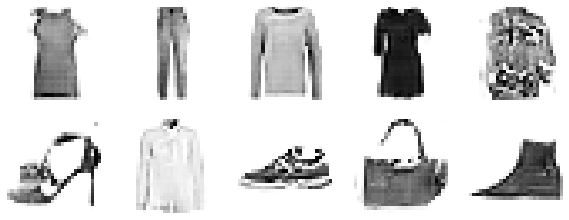

In [ ]:
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

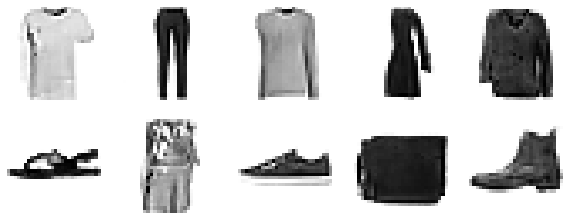

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim)

In [ ]:
# model_path = r'/content/drive/My Drive/CGAN/model/'
# g_model.save(model_path + 'cgan_generator.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


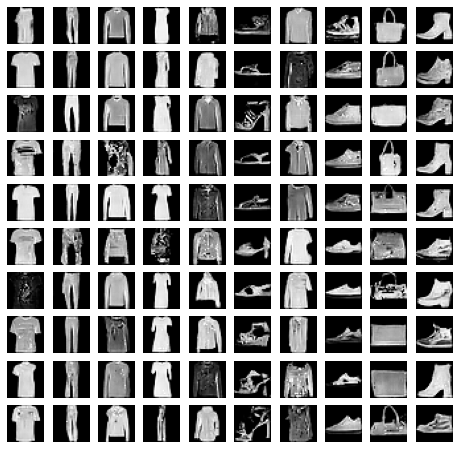

In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# # generate points in latent space as input for the generator
pyplot.figure(figsize=(8,8))
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0],cmap ='gray')
    pyplot.show()

# load model
model = load_model(r'/content/drive/My Drive/CGAN_2/model/cgan_generator_at_epoch_0195.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
# X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)